# ABT

In [1]:
%matplotlib inline

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu

# Matplotlib
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (16, 8)

In [2]:
%%capture
# R
from rpy2.robjects.packages import importr
from rpy2.robjects import R, pandas2ri as pd2
importr("utils").chooseCRANmirror(ind=1);
%reload_ext rpy2.ipython
pd2.activate()

Скачаем и установим пакет `Matching` для функции `ks.boot`.

In [3]:
%%capture
%R install.packages('Matching')
%R require('Matching')

## Data

In [4]:
%time df = pd.read_hdf('clean_data.h5')
df.dtypes

CPU times: user 1.97 s, sys: 357 ms, total: 2.32 s
Wall time: 2.4 s


date       datetime64[ns]
user                int64
browser          category
clicks              int64
slot             category
dtype: object

## Task 1

In [56]:
def slot_split(df, metric='sum'):
    groups = df.groupby('user')['clicks']
    if metric == 'sum':
        uclicks = groups.sum()
    elif metric == 'mean':
        uclicks = groups.mean()
    elif metric == 'nzctr':
        uclicks = groups.agg(lambda _: sum(_) / len(_ != 0))
    elif metric == 'zrate':
        uclicks = groups.agg(lambda _: sum(_ == 0) / len(_))
    elif metric == 'nzcnt':
        uclicks = groups.agg(lambda _: len(_ != 0))
    else:
        raise ValueError('No such metric func.')
    control = uclicks.loc[np.unique(df.user[df.slot == 'control'])]
    exp = uclicks.loc[np.unique(df.user[df.slot == 'exp'])]
    return control, exp

In [27]:
control, exp = slot_split(df)
len(control), len(exp)

(284392, 281450)

In [7]:
np.mean(control), np.mean(exp)

(11.287332273762974, 11.589351572215314)

Будем проверять, что среднее в `control` меньше среднего в `exp`.

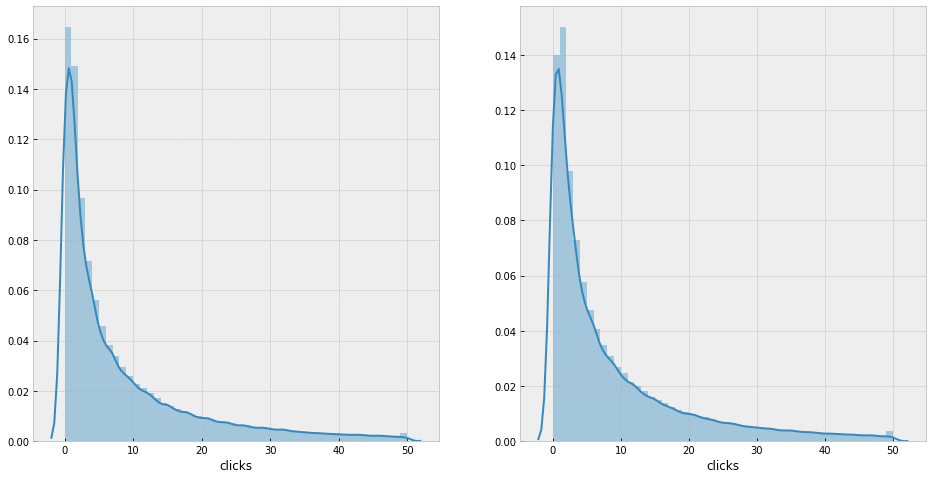

In [8]:
_, axs = plt.subplots(ncols=2)
sns.distplot(control[control <= 50], ax=axs[0])
sns.distplot(exp[exp <= 50], ax=axs[1]);

В формальных ограничениях для теста Манна-Уитни можно найти:  

>В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10).

Что не верно для выборок `control` и `exp`. Поэтому нужно воспользоваться других тестом. Например, подойдет `ks.boot` из R (в частности, он подходит для дискретных распределений, что хорошо).

In [9]:
%Rpush control exp
%time %R stats <- ks.boot(exp, control, 10, alternative='less')

CPU times: user 8.07 s, sys: 604 ms, total: 8.67 s
Wall time: 8.77 s


ks.boot.pvalue
0.000000
ks
statistic
0.023833
p.value
0.000000
alternative
'the CDF of x lies below that of y'
method
'Two-sample Kolmogorov-Smirnov test'


Но, вообще-то говоря, Манна-Уитни можно использовать для дискретных распределений, которые хорошо приближают непрерывное (об этом написано, например, здесь http://www.alglib.net/hypothesistesting/mannwhitneyu.php). На графиках видно, что это так, поэтому посчитаем pvalue с помощью Манна-Уитни тоже. Реализация из scipy умеет работать и с дискретными распределениями.

In [10]:
_, pvalue = mannwhitneyu(control, exp, alternative='less')
pvalue

4.3471471887604393e-75

Итак, с большой увереностью, E[`control`] < E[`exp`].

## Task 2

Локализуется ли изменение кликов в каком-либо срезе?

Грубо говоря, срезу можно взять всего 3: по `date`, по `browser` и по парам `date/browser`.  
В качестве аггрегирующей функции берем среднее, чтобы не париться с разным количеством юзеров.  
Посмотрим на каждый из них.

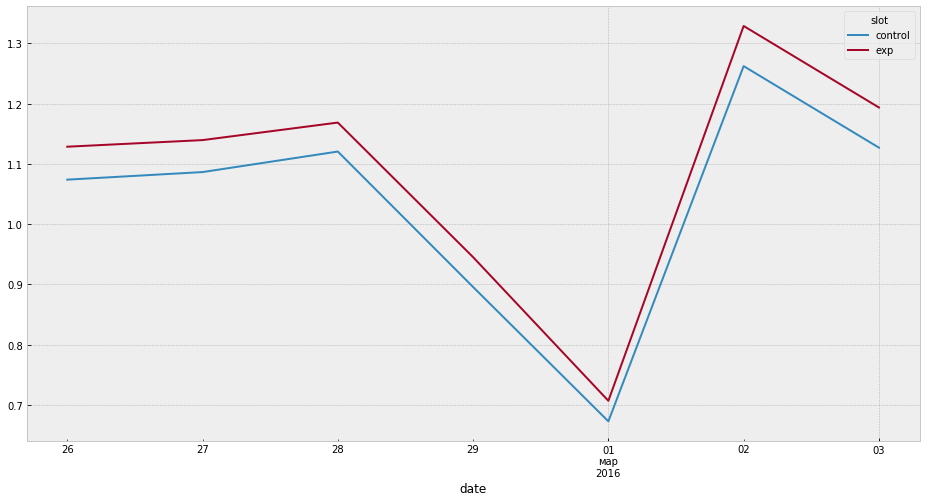

In [11]:
df.pivot_table(values='clicks', index='date', columns='slot', aggfunc=np.mean).plot();

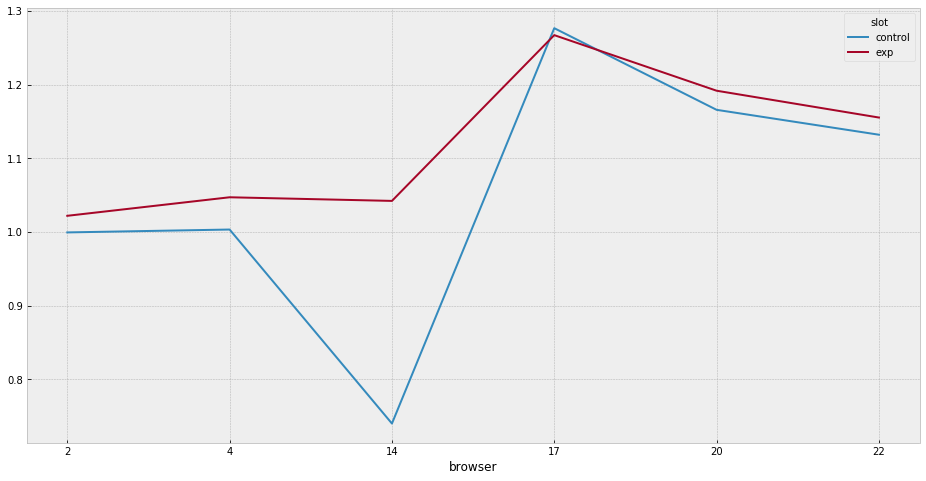

In [12]:
df.pivot_table(values='clicks', index='browser', columns='slot', aggfunc=np.mean).plot();

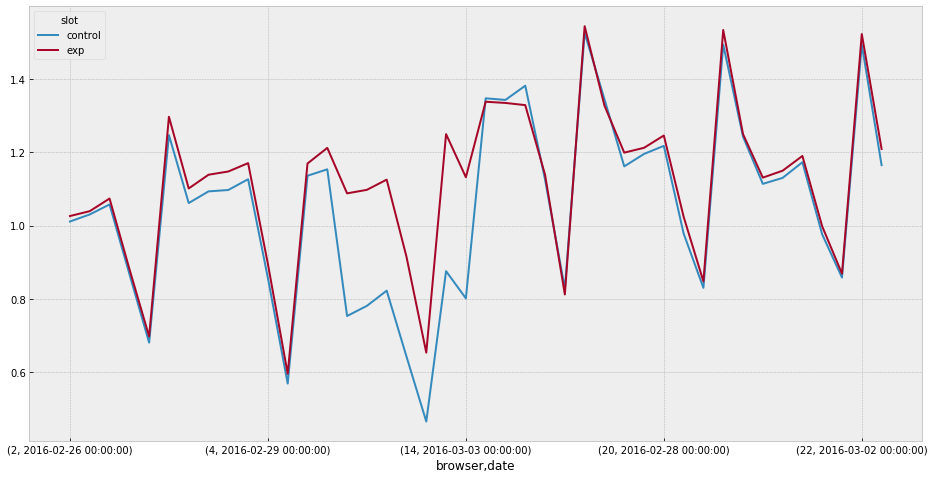

In [13]:
df.pivot_table(values='clicks', index=['browser', 'date'], 
               columns='slot', aggfunc=np.mean).plot();

Последние два хорошо локализуют изменения кликов. Оно произошло на 14 браузере.
Посмотрим на подмножество `browser == 14`, спайк на котором хорошо виден на последних двух срезах.

In [14]:
df14 = df[df.browser == 14]
del df14['browser']
df14.reset_index(drop=True, inplace=True)
df14.dtypes

date      datetime64[ns]
user               int64
clicks             int64
slot            category
dtype: object

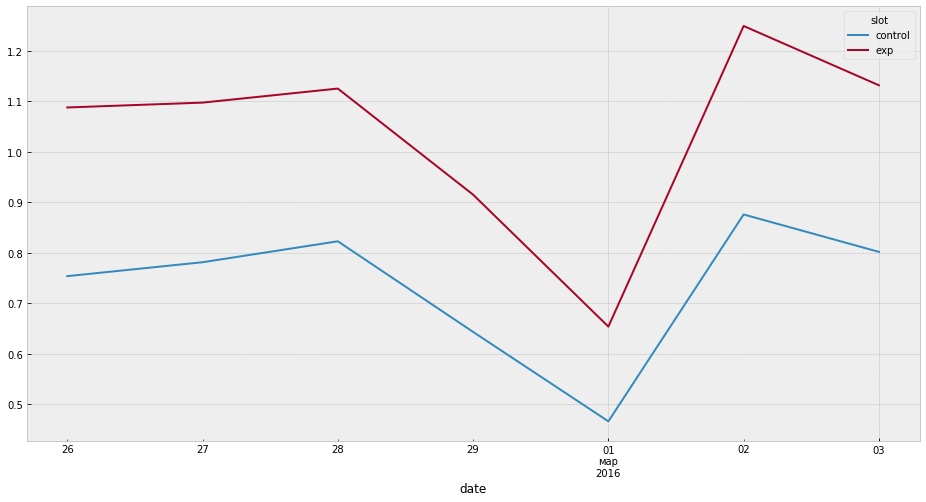

In [15]:
df14.pivot_table(values='clicks', index='date', columns='slot', aggfunc=np.mean).plot();

Проверим значимость различия статистически.

In [23]:
control, exp = slot_split(df14)
_, pvalue = mannwhitneyu(control, exp, alternative='less')
pvalue

0.0

## Task 3

Можно ли по предложенным данным предположить, положительный эффект имело экспериментальное изменение, или отрицательный?

Нет. Изменения по других браузерам не видны, спайка на 14ом может объясняться его особенностью.  
Отбросим данные по 14 браузеру и еще раз проанализируем данные.

In [17]:
dfn14 = df[df.browser != 14]
del dfn14['browser']
dfn14.reset_index(drop=True, inplace=True)
dfn14.dtypes

date      datetime64[ns]
user               int64
clicks             int64
slot            category
dtype: object

In [18]:
control, exp = slot_split(dfn14)
len(control), len(exp)

(239497, 237236)

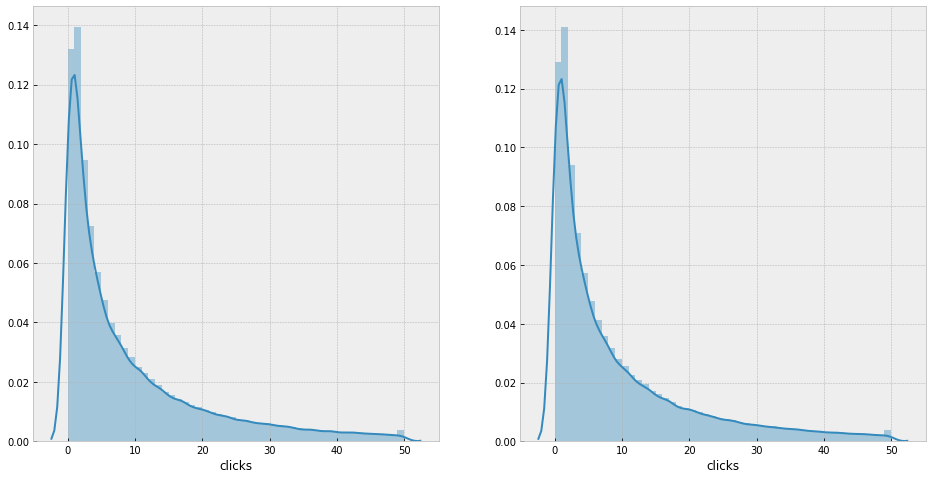

In [19]:
_, axs = plt.subplots(ncols=2)
sns.distplot(control[control <= 50], ax=axs[0])
sns.distplot(exp[exp <= 50], ax=axs[1]);

In [20]:
_, pvalue = mannwhitneyu(control, exp)
pvalue

0.089386396963443915

Итак, `pvalue` > 0.05 и гипотеза отвергается.  
Поэтому увеличение числа кликов до удаления 14 браузера может объясняться не отличием `exp` группы от `control` группы (новой фичей), а некой особенностью 14 браузера (которая, возможно, связана с имплипентируемой фичей).  
Например, в для `exp` группы реализуется перерисовка иконок, которые корректно отображаются во всех браузерах, а для `control` группы иконки старые, но в 14 браузере они неправильно подгружаются и свертка едет.  
Возвращаясь к ответу на вопрос: сделать предположение о том, что имел место положительный эффект, конечно, можно, но его надо перепроверить и расследовать особенность на 14 браузере, а строго доказать предположение, увы, не получится.

## Bonus

Как еще можно агрегировать данные, чтобы сделать распределение более "похожим" на непрерывное, тем самым уменьшив количество ties?

Я попробовал много метрик. Лучше всего получилось с "количеством запросов хотя бы с одним кликом".

CPU times: user 882 ms, sys: 189 ms, total: 1.07 s
Wall time: 1.07 s


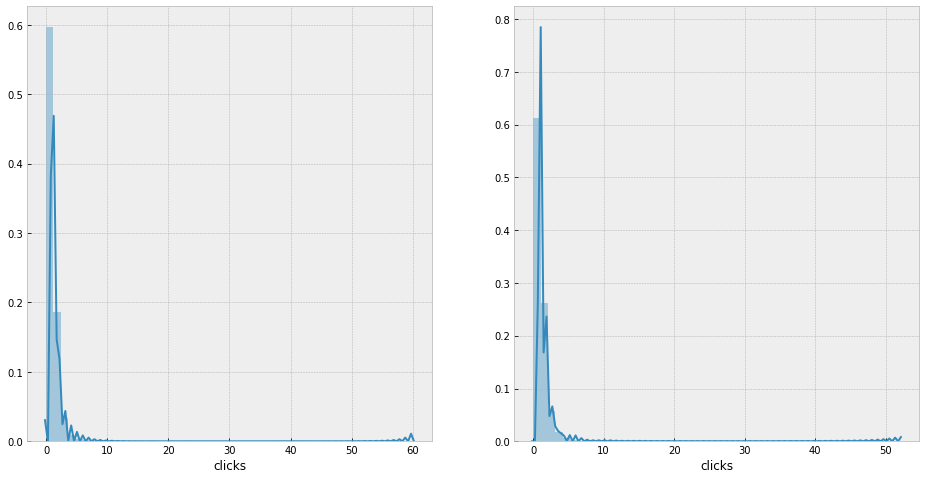

In [75]:
%%time
control, exp = slot_split(df, 'mean')
_, axs = plt.subplots(ncols=2)
sns.distplot(control[control <= 100], ax=axs[0])
sns.distplot(exp[exp <= 100], ax=axs[1]);

In [76]:
_, pvalue = mannwhitneyu(control, exp, alternative='less')
pvalue

3.1629583858467e-308